In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import copy

# Add the utils directory to the Python path and import utils
from utils import *
from MLPQLearningAgent import *
from OracleQLearningAgent import *
from TransitionModelLearner import *


In [2]:
grid_world = GridWorld(
    n_rows=25,
    n_cols=25,
    start=(0, 0),
    goal=(24, 24),
    walls = WALLS,
    step_reward= -0.1,
    goal_reward=1,
    bump_reward=-0.2,
    gamma=0.95
)

def oracle_model(s, action):
    """Oracle model that predicts the next state for all 8 actions (including diagonal actions 4-7)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), action, ACTIONS_8)
    return s_model_next

In [3]:
  # 1. Q-learning with 4 actions
agent_plain_4_action = QLearningAgent(grid_world, 4, seed=42)
agent_plain_4_action.train(ACTIONS_4, epsilon_greedy)
results_plain = agent_plain_4_action.get_results(moving_average)

# ----------------------------------------
policy4 = Visualizer.derive_policy(agent_plain_4_action.Q, N_ROWS, N_COLS)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(agent_plain_4_action.Q, N_ROWS, N_COLS)

# 3. Oracle Q-learning with 5 actions 
oracle_agent_run = OracleQLearningAgent(grid_world, len(ACTIONS_8), base_q_table = copy.deepcopy(agent_plain_4_action.Q), seed=42)
oracle_agent_run.train_with_oracle(ACTIONS_8, epsilon_greedy, oracle_model)
oracle_results_run = oracle_agent_run.get_results(moving_average)
# ----------------------------------------
policy5 = Visualizer.derive_policy(oracle_agent_run.Q, N_ROWS, N_COLS)
Visualizer.render_policy(policy5, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(oracle_agent_run.Q, N_ROWS, N_COLS)

Bump at state index 0 on episode 574, step 0, action 3, bumpcount 0
Bump at state index 25 on episode 574, step 2, action 1, bumpcount 1
Bump at state index 25 on episode 574, step 3, action 0, bumpcount 2
Bump at state index 25 on episode 574, step 4, action 2, bumpcount 3
Bump at state index 154 on episode 574, step 16, action 1, bumpcount 4
Bump at state index 154 on episode 574, step 17, action 1, bumpcount 5
Bump at state index 154 on episode 574, step 18, action 1, bumpcount 6
Bump at state index 154 on episode 574, step 19, action 3, bumpcount 7
Bump at state index 154 on episode 574, step 26, action 1, bumpcount 8
Bump at state index 154 on episode 574, step 27, action 3, bumpcount 9
Bump at state index 153 on episode 574, step 29, action 0, bumpcount 10
Bump at state index 153 on episode 574, step 30, action 1, bumpcount 11
Bump at state index 154 on episode 574, step 34, action 2, bumpcount 12
Bump at state index 152 on episode 574, step 39, action 3, bumpcount 13
Bump at sta

Running multiple experiments for statistical analysis...
Running experiment 1/5...
Bump at state index 0 on episode 574, step 0, action 1, bumpcount 0
Bump at state index 0 on episode 574, step 3, action 3, bumpcount 1
Bump at state index 0 on episode 574, step 4, action 1, bumpcount 2
Bump at state index 0 on episode 574, step 5, action 2, bumpcount 3
Bump at state index 0 on episode 574, step 6, action 0, bumpcount 4
Bump at state index 28 on episode 574, step 13, action 3, bumpcount 5
Bump at state index 28 on episode 574, step 14, action 3, bumpcount 6
Bump at state index 53 on episode 574, step 16, action 1, bumpcount 7
Bump at state index 54 on episode 574, step 18, action 1, bumpcount 8
Bump at state index 54 on episode 574, step 19, action 1, bumpcount 9
Bump at state index 55 on episode 574, step 21, action 0, bumpcount 10
Bump at state index 55 on episode 574, step 22, action 3, bumpcount 11
Bump at state index 80 on episode 574, step 24, action 3, bumpcount 12
Bump at state 

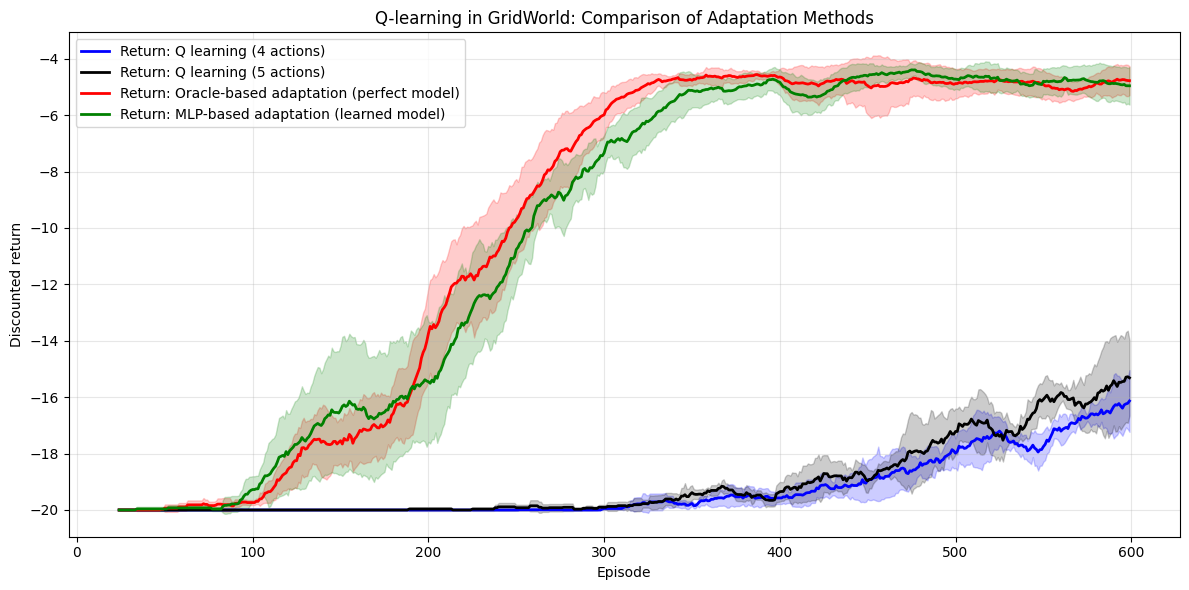

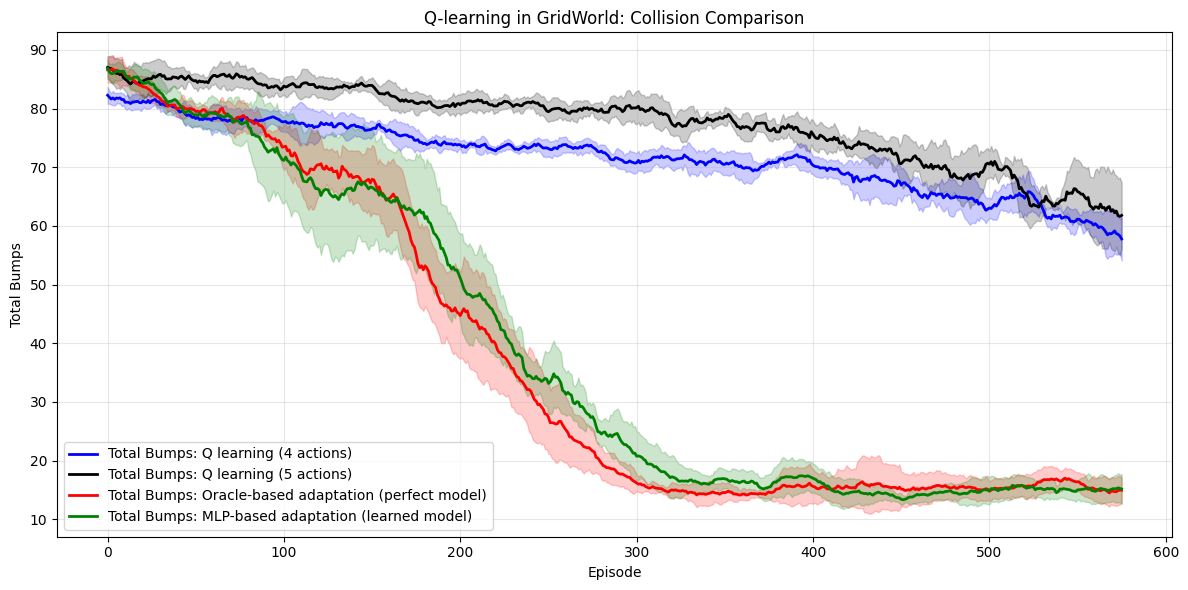

In [4]:
EPISODES = 600

def run_multiple_experiments(n_runs=5, base_seed=123):
    """Run multiple experiments with different seeds and return statistics"""
    
    # Storage for all runs
    all_returns4 = []
    all_returns5plain = []
    all_returns5oracle = []
    all_returns5mlp = []
    all_returns5ignore = []
    all_bumps4 = []
    all_bumps5plain = []
    all_bumps5oracle = []
    all_bumps5mlp = []
    all_bumps5ignore = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        torch.manual_seed(current_seed)
        
        print(f"Running experiment {run + 1}/{n_runs}...")
        
        # 1. Q-learning with 4 actions
        agent_plain_4_action = QLearningAgent(grid_world = grid_world, n_actions= 4, episodes = EPISODES, seed=current_seed)
        agent_plain_4_action.train(ACTIONS_4, epsilon_greedy)
        results_plain = agent_plain_4_action.get_results(moving_average)
        all_returns4.append(results_plain['returns'])
        all_bumps4.append(results_plain['bumps'])
        
        # 4. MLP Q-learning with learned model
        mlp_agent = MLPQLearningAgent(grid_world = grid_world, n_actions = len(ACTIONS_8), episodes = EPISODES,
                                      base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed)
        mlp_agent.train_with_learned_model(ACTIONS_8, epsilon_greedy)
        mlp_results = mlp_agent.get_results(moving_average)
        all_returns5mlp.append(mlp_results['returns'])
        all_bumps5mlp.append(mlp_results['bumps'])
        
        oracle_agent_run = OracleQLearningAgent(grid_world = grid_world, n_actions = len(ACTIONS_8),
                                                episodes = EPISODES, base_q_table=copy.deepcopy(agent_plain_4_action.Q),
                                                seed=current_seed)
        
        oracle_agent_run.train_with_oracle(ACTIONS_8, epsilon_greedy, oracle_model)
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        all_returns5oracle.append(oracle_results_run['returns'])
        all_bumps5oracle.append(oracle_results_run['bumps'])
        
        agent_plain = QLearningAgent(grid_world = grid_world, n_actions = len(ACTIONS_8), episodes = EPISODES, seed=current_seed)
        agent_plain.train(ACTIONS_8, epsilon_greedy)
        results_plain = agent_plain.get_results(moving_average)
        all_returns5plain.append(results_plain['returns'])
        all_bumps5plain.append(results_plain['bumps'])
        
    # Calculate statistics
    all_returns4 = np.array(all_returns4)
    all_returns5plain = np.array(all_returns5plain)
    all_returns5oracle = np.array(all_returns5oracle)
    all_returns5mlp = np.array(all_returns5mlp)
    all_returns5ignore = np.array(all_returns5ignore)
    all_bumps4 = np.array(all_bumps4)
    all_bumps5plain = np.array(all_bumps5plain)
    all_bumps5oracle = np.array(all_bumps5oracle)
    all_bumps5mlp = np.array(all_bumps5mlp)
    all_bumps5ignore = np.array(all_bumps5ignore)
    
    # Calculate moving averages for all runs
    ma_w = 25
    all_ret_ma4 = np.array([moving_average(returns, w=ma_w) for returns in all_returns4])
    all_ret_ma5plain = np.array([moving_average(returns, w=ma_w) for returns in all_returns5plain])
    all_ret_ma5oracle = np.array([moving_average(returns, w=ma_w) for returns in all_returns5oracle])
    all_ret_ma5mlp = np.array([moving_average(returns, w=ma_w) for returns in all_returns5mlp])
    
    all_bumps4_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps4])
    all_bumps5plain_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5plain])
    all_bumps5oracle_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5oracle])
    all_bumps5mlp_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5mlp])
    
    return {
        'returns': {
            '4_actions': {'mean': np.mean(all_ret_ma4, axis=0), 'std': np.std(all_ret_ma4, axis=0)},
            '5_plain': {'mean': np.mean(all_ret_ma5plain, axis=0), 'std': np.std(all_ret_ma5plain, axis=0)},
            '5_oracle': {'mean': np.mean(all_ret_ma5oracle, axis=0), 'std': np.std(all_ret_ma5oracle, axis=0)},
            '5_mlp': {'mean': np.mean(all_ret_ma5mlp, axis=0), 'std': np.std(all_ret_ma5mlp, axis=0)},
        },
        'bumps': {
            '4_actions': {'mean': np.mean(all_bumps4_avg, axis=0), 'std': np.std(all_bumps4_avg, axis=0)},
            '5_plain': {'mean': np.mean(all_bumps5plain_avg, axis=0), 'std': np.std(all_bumps5plain_avg, axis=0)},
            '5_oracle': {'mean': np.mean(all_bumps5oracle_avg, axis=0), 'std': np.std(all_bumps5oracle_avg, axis=0)},
            '5_mlp': {'mean': np.mean(all_bumps5mlp_avg, axis=0), 'std': np.std(all_bumps5mlp_avg, axis=0)},
        }
    }

# Run multiple experiments
print("Running multiple experiments for statistical analysis...")
stats = run_multiple_experiments(n_runs=5)  # Reduced runs for faster execution

# Plot results with shaded error bars
def plot_with_shaded_errors(stats, figsize=(12, 6)):
    """Plot results with shaded error bars"""
    
    # Returns plot
    plt.figure(figsize=figsize)
    
    # Calculate x-axis for each series (they might have different lengths due to moving average)
    episodes_total = EPISODES
    ma_w = 25
    
    # Plot each method with shaded error bars
    methods = [
        ('4_actions', 'Q learning (4 actions)', 'blue'),
        ('5_plain', 'Q learning (5 actions)', 'black'), 
        ('5_oracle', 'Oracle-based adaptation (perfect model)', 'red'),
        ('5_mlp', 'MLP-based adaptation (learned model)', 'green'),
    ]
    
    for method_key, label, color in methods:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Discounted return')
    plt.title('Q-learning in GridWorld: Comparison of Adaptation Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bumps plot
    plt.figure(figsize=figsize)
    
    for method_key, label, color in methods:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Bumps')
    plt.title('Q-learning in GridWorld: Collision Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the results with shaded error bars
plot_with_shaded_errors(stats)